In [1]:
import os
os.chdir('..')

# Step 1: Download the MNIST dataset

In [2]:
!pip3 install torchvision

In [18]:
from torchvision.transforms import Compose, Normalize, ToTensor
import torchvision

transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)


# Step 2: Build the model

In [4]:
from Adversarial_Observation import utils

In [5]:
model = utils.build_cnn()
print(model)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=784, out_features=10, bias=True)
  (8): Softmax(dim=1)
)


In [6]:
# define the training loop
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# define the testing loop
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
epochs = 1

for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)
    print('Epoch: {}, Test Loss: {}, Test Accuracy: {}'.format(epoch, test_loss, test_accuracy))

Epoch: 0, Test Loss: 0.023189729380607604, Test Accuracy: 98.46


In [ ]:
# save the model
torch.save(model.state_dict(), './MNIST_CNN.pt')

# Step 3: Reduce the model using PCA

In [6]:
!pip3 install sklearn
!pip3 install tqdm
from sklearn.decomposition import PCA
import pickle as pkl
import numpy as np
from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [23]:
X = mnist_train.data.numpy().reshape(-1, 784)
y = mnist_train.targets.numpy()


In [24]:
X.shape

(60000, 784)

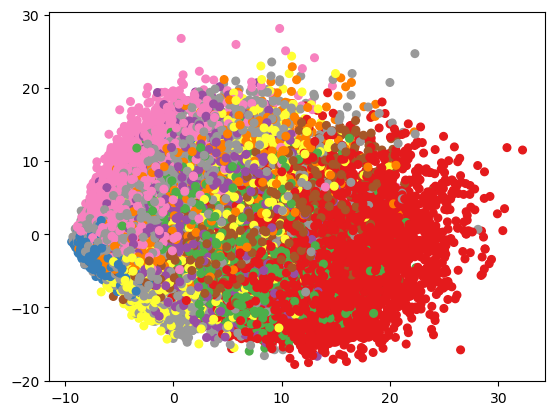

In [25]:
pca_2d = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=0))
pca_2d.fit(X, y)
X_pca_2d = pca_2d.transform(X)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, s=30, cmap='Set1')


In [26]:
np.save('MNIST_Reduced_Data.npy', X_pca_2d)
np.save('MNIST_Reduced_Labels.npy', y)

In [27]:
pkl.dump(pca_2d, open('MNIST_PCA.pkl', 'wb'))